# Policy Gradient Reinforcement Learning

## General Overview

This notebook demonstrates a simple but general implementation of policy gradient reinforcement learning (for discrete actions).

The code is split into:

PolicyGradient -- a class that implements the learning algorithm itself
            and will make use of an 'agent' and an 'environment' that
            are defined elsewhere. This is general and can be used for
            any kind of (discrete-action) reinforcement learning task.

QubitEnvironment -- a class that implements the environment for
            a specific task (see below). The interface to this
            class (i.e. the methods) is general and can also be
            used for other tasks.

...plus code that sets up the agent as a network and code that actually runs the training and visualizes the results.

Two noteworthy aspects here are: the use of batches (i.e. many trajectories can be processed in parallel, adding an extra dimension to every array, like states and actions and rewards) and the function ‘sample’ that selects a random action given a set of probabilities (provided by the policy). The latter is a bit involved since we try to deal with batches.

## Physics Scenario

The particular scenario we consider here is inspired by quantum physics. Consider a spin and represent it by a single unit vector (the so-called Bloch vector). Imagine this vector starts out pointing in some (possibly random) direction, and our goal is to implement a series of rotations such that in the end the vector aligns as closely as possible with some target direction.

Assume that only two different rotations can be applied (e.g. a rotation around the x-axis by some angle phi_x and another rotation around the z-axis, by some angle phi_z). Can the agent find a strategy that rotates a random initial vector in a fixed number of steps into the desired direction?

The state is given by the current unit vector (Bloch vector) and there are only two actions (a=0,1) corresponding to the two possible rotations. The reward is supplied only at the final time and is essentially the scalar product between the Bloch vector at the final time and the target vector.

(C) 2022 Tirth Shah and Florian Marquardt, Theory Division at the Max Planck Institute for the Science of Light. MIT License.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as tfk
from tqdm import trange
import matplotlib.pyplot as plt

## Brief reminder of policy gradient reinforcement learning, illustrated for this example

state s  = qubit state (pure)

      s = Bloch vector = (n_x,n_y,n_z) where n = <Psi|sigma_vector|Psi>
 
Note the *observed* state, passed to the agent, is a 4D vector, where the last entry is the current time step index. This allows the agent to react differently at the beginning of the trajectory and later.


Actions

      actions = rotations of the qubit around two possible axes, and for each axis a fixed angle


Policy

      policy = pi(a|s) = action probabilities

Reward and return

      reward = (only final reward) = |<Psi(T)|Psi_target>| = 0.5*(1+ n * n_target)

      return R = cumulative rewards = final reward


Policy gradient method 'REINFORCE', in one line

 (parametrize policy, e.g. neural network)

    d theta = eta sum_t E[ R * (d/dtheta) ln pi_theta(a_t|s_t) ]

 method:  run trajectories, record s_0,a_0,s_1,...,s_T and R, 
 then apply this d theta update



## The policy gradient RL learner class

This is the general code that could be re-used for any other kind of scenario.

In [2]:
def sample(probs):
    """
    A function that, given probability distributions probs
    (of shape [batchsize,bins]) for discrete events, samples
    from these distributions. It returns an integer array of shape [batchsize]
    which contains the random integer numbers that are distributed
    according to probs. That is, result[j] is distributed according to probs[j,:].
    """
    # get cumulative distribution for each sample:
    prob_cumsum=np.cumsum(probs,axis=-1)
    # pick a random number between 0 and 1 for each sample:
    random_number=np.random.uniform(size=probs.shape[:-1])
    # return the selected index for each sample:
    return np.argmax(random_number[...,None]<prob_cumsum,axis=-1)

class SimplePolicyGradient:
    def __init__(self,batchsize,num_steps,agent,environment,learning_rate=1e-3):
        """
        Set up a policy gradient reinforcement learner that can process
        batches of states and actions in parallel.

        batchsize:
            The batchsize.

        num_steps:
            Number of time steps in a trajectory.

        agent:
            One has to be able to call agent(state), which acts on a batch
            of states of shape [batchsize,...], where ... is defined by environment.
            Returns a set of action probabilities, shape [batchsize,num_actions].
            This could simply be a keras Model with the right input dimensions (defined
            by the environment) and the right number of output neurons for the
            desired number of actions, using softmax (compatible with environment).
            Besides being able to act on a state and return the policy, it also
            has to supply agent.trainable_variables (this will automatically be the
            case for any keras model).
        
        environment:
            Has to implement env.prepare_initial_state(batchsize),
            env.provide_observed_state(), and env.perform_action(action,time_step,num_steps).
            env.provide_observed_state() returns the current observed state (a batch), while
            perform_action returns the reward (batch of rewards) after performing action.
        """
        self.batchsize=batchsize
        self.num_steps=num_steps
        self.agent=agent
        self.environment=environment
        self.learning_rate = learning_rate
        self.return_history = []
        self.optimizer=tfk.optimizers.Adam(learning_rate=self.learning_rate)

    def run_trajectory(self):
        """
        Run a single trajectory and update self.return_R and
        self.state_history and self.action_history.
        """
        self.environment.prepare_initial_state(self.batchsize)
        self.return_R=np.zeros([self.batchsize])
        for time_step in range(self.num_steps):
            state=self.environment.provide_observed_state()
            action_probabilities=self.agent(state) # shape [batchsize,num_actions]
            action=sample(action_probabilities) # shape [batchsize]
            reward=self.environment.perform_action(action,time_step,num_steps)
            self.return_R += reward
            if time_step==0:
                self.state_history = np.zeros([self.num_steps]+list(state.shape))
                self.action_history = np.zeros([self.num_steps, self.batchsize],dtype='int')
            self.state_history[time_step,...]=state
            self.action_history[time_step,:]=action

    def update_policy_gradient(self):
        """
        Call this after having run a trajectory. This uses the
        cumulative reward that was recorded, together with the
        history of states and actions, to update the policy of the agent.
        """
        idx=np.arange(self.batchsize)

        for time_step in range(self.num_steps):
            with tf.GradientTape() as tape:
                # now calculate R * ln pi(a_t|s_t), within the gradient tape

                # evaluate policy probabilities at this time step (a full batch of prob. distributions)
                action_probs = agent(self.state_history[time_step,...])
                # now fill an array of the same shape, inserting the return R at only
                # the slot of the action that was actually performed, for each sample in the batch:
                selected_actions=np.zeros(action_probs.shape)
                selected_actions[idx,self.action_history[time_step,:]]=-self.return_R
                # Now, for the loss, calculate - R * ln pi(a_t|s_t) for the
                # selected actions, averaged over the batch!
                # Note: We used the - sign  above because the loss will be *minimized*.
                # Note: this is really a categorical cross-entropy, except we multiplied with R for
                # each sample!
                loss = tf.reduce_mean(selected_actions * tf.math.log(action_probs))
            # get the gradient that is needed for policy gradient
            grads = tape.gradient(loss, agent.trainable_variables)
            # applying the gradient immediately involves a certain approximation,
            # namely the policy will now already have changed a bit when we go to
            # evaluate it in the next time step. Nevertheless, this keeps things
            # simple. Should not matter too much if learning rate is small enough.
            self.optimizer.apply_gradients(zip(grads,agent.trainable_variables))
                
    def train(self,train_steps):
        for step in trange(train_steps):
            self.run_trajectory()
            self.update_policy_gradient()
            self.return_history.append(np.mean(self.return_R))


        

## The physics environment (a qubit)

In [3]:
def rotation_matrix(rot_axis, rot_angle):
    '''
    Rotation matrix about the axis x,y,z (rot_axis=0,1,2) for 
    angle rot_angle (in radians)
    '''

    rot_matrix = np.zeros([3,3])
    rot_matrix[rot_axis,rot_axis] = 1
    rot_matrix[(rot_axis+1)%3,(rot_axis+1)%3] = np.cos(rot_angle)
    rot_matrix[(rot_axis+1)%3,(rot_axis+2)%3] = -np.sin(rot_angle)
    rot_matrix[(rot_axis+2)%3,(rot_axis+1)%3] = np.sin(rot_angle)
    rot_matrix[(rot_axis+2)%3,(rot_axis+2)%3] = np.cos(rot_angle)

    return rot_matrix

class QubitEnvironment:
    """
    All the call interfaces here are general, except for the init method
    (and of course except for the 'overlap' method).
    """
    def __init__(self,action_matrix,target_state,num_actions,state_dimension,
                reward_all=False):
        """
        Set up parameters of the environment.
        """
        self.action_matrix = action_matrix
        self.num_actions = num_actions
        self.state_dimension = state_dimension
        self.reward_all = reward_all
        self.target_state = target_state

    def prepare_initial_state(self,batchsize):
        """
        Prepare internally the state at the starting point of
        a trajectory (actually, a batch of states, given by batchsize).
        """
        # last dimension in the state corresponds to the Bloch vector = (n_x,n_y,n_z)
        self.state = np.random.random(size=[batchsize,self.state_dimension])*2-1 # should be in the range [-1,1]
        self.state = self.state/(np.linalg.norm(self.state, axis=-1)[:,None])
        self.current_time_step=0
        self.batchsize=batchsize

    def provide_observed_state(self):
        """
        Return the current observed state, to be given to the agent. (actually, a batch of states, of
        some shape [batchsize,...]).
        """
        observed_state=np.zeros([self.batchsize,self.state_dimension+1])
        # now include the time index in the state that is observed by the agent:
        observed_state[:,:-1]=self.state
        observed_state[:,-1]=self.current_time_step
        return observed_state

    def perform_action(self,action,time_step,num_steps):
        """
        Perform actions 'action' (shape: [batchsize]) in parallel
        on a batch, updating the internal state, and return an array
        of rewards (shape: [batchsize]).

        time_step: current time step (0 will be first)
        num_step:  maximum number of time_steps (time_step == num_steps-1 will indicate last)

        Here the actions refer to the application of different rotations,
        which are provided as matrices when setting up the environment.
        """
        
        # Perform the action on the states to obtain the new states
        new_state = np.zeros((self.state).shape)
        for action_idx in range(self.num_actions):
            mask = np.argwhere(action==action_idx)[:,0]
            new_state[mask,...] = np.matmul(self.action_matrix[action_idx,...], 
                                            self.state[mask,...].T).T

        self.state = new_state
        self.current_time_step = time_step

        if self.reward_all: # reward is evaluated at all the time steps
            return self.overlap(self.state,self.target_state)
        
        else: # reward is evaluated only at the final time step
            if time_step==num_steps-1:
                return self.overlap(self.state,self.target_state)
            else:
                return 0
        
    def overlap(self,state,target_state):
        '''
        Evaluate the overlap of the state and the target state.
        Overlap = 0.5*(1+ n * n_target)
        
        state is of the shape [:,state_dimension]
        target_state is of the shape [state_dimension]
        '''
        dot_product = np.sum(state*target_state[None,:], axis=-1)
        return 0.5*(1 + dot_product) # reward = 0.5*(1+ n * n_target)

## Some small tests for the probabilistic selection of actions

Test the sample function (sampling according to given probability distribution)

In [4]:
# little toy example of generating numbers
# according to a given probability distribution
probs=[0.3,0.5,0.2]
probs_cum=np.cumsum(probs)
counter=np.zeros(3)
for _ in range(1000):
    x=np.random.uniform()
    result=np.where(x<probs_cum)[0][0]
    counter[result]+=1
# print frequencies:
print("Observed:", counter/1000)
print("Expected:", probs)

Observed: [0.303 0.508 0.189]
Expected: [0.3, 0.5, 0.2]


In [5]:
# Checking the batch-enabled sample function that is used by us:

probs=np.array([[0.3,0.5,0.2],[0.7,0.2,0.1]]) # shape [2,3]

counter=np.zeros(probs.shape)
for _ in range(1000):
    result = sample(probs)    
    for sample_idx in range(probs.shape[0]):
        counter[sample_idx,result[sample_idx]]+=1
    
print("Observed:", counter/1000)
print("Expected:", probs)

Observed: [[0.289 0.51  0.201]
 [0.703 0.195 0.102]]
Expected: [[0.3 0.5 0.2]
 [0.7 0.2 0.1]]


## Perform the training

### Initialize physics (environment) properties

In [6]:
# Selecting the two rotation axes and the corresponding angles
# here you could choose different axes and angles.
rot_axis = [0,2] # rotation axis (0,1,2) -> (x,y,z) axis
rot_angle = [np.pi/8, np.pi/8] # angle of rotation about the two axes

# Obtain the action matrices (2 rotation matrices and an identity matrix)
num_actions = 3
action_matrix = np.zeros([num_actions,3,3]) # shape [num_action matrices, xyz, xyz]
action_matrix[0,...] = rotation_matrix(rot_axis=rot_axis[0], rot_angle=rot_angle[0])
action_matrix[1,...] = rotation_matrix(rot_axis=rot_axis[1], rot_angle=rot_angle[1])
action_matrix[2,...] = rotation_matrix(rot_axis=0, rot_angle=0)


state_dimension = 3 # Bloch vector's 3 dimensions
target_state = np.array([2.5,0.6,1]) # Bloch vector of the target state
target_state = target_state/np.linalg.norm(target_state) # normalization

# Environment
# reward_all=True -> return is the sum of overlaps at all the time steps
# reward_all=False -> return is the overlap at the final time step
environment = QubitEnvironment(action_matrix,target_state=target_state,
                  num_actions=num_actions,state_dimension=state_dimension,
                  reward_all=False)

### Initialize agent and RL policy gradient learner

In [7]:
# Agent policy network

# Initialize the policy neural network that returnsthe actin probabilities: pi(a_t|s_t).
layers = [10,10] # List containing the number of neurons in each hidden layer
N_in = state_dimension+1 # number of neurons in the input layer (state_dimension + time_step)
N_out = num_actions # number of neurons in the output layer
       
Dense = tfk.layers.Dense
agent = tfk.Sequential([Dense(layers[0], activation='relu', input_shape=(N_in,))] + 
                     [Dense(n, activation='relu') for n in layers[1:]] +
                     [Dense(N_out, activation='softmax')]
                    )

# Learner

batchsize = 32
num_steps = 10 # maximum number of time steps during each run

learner = SimplePolicyGradient(batchsize,num_steps,agent,environment,learning_rate=1e-3) # Define the RL policy

### The actual training

In [8]:
train_steps = 200

learner.train(train_steps=train_steps) # Perform the training

100%|██████████| 200/200 [00:22<00:00,  8.99it/s]


## Visualization of the results

### Average return vs training step

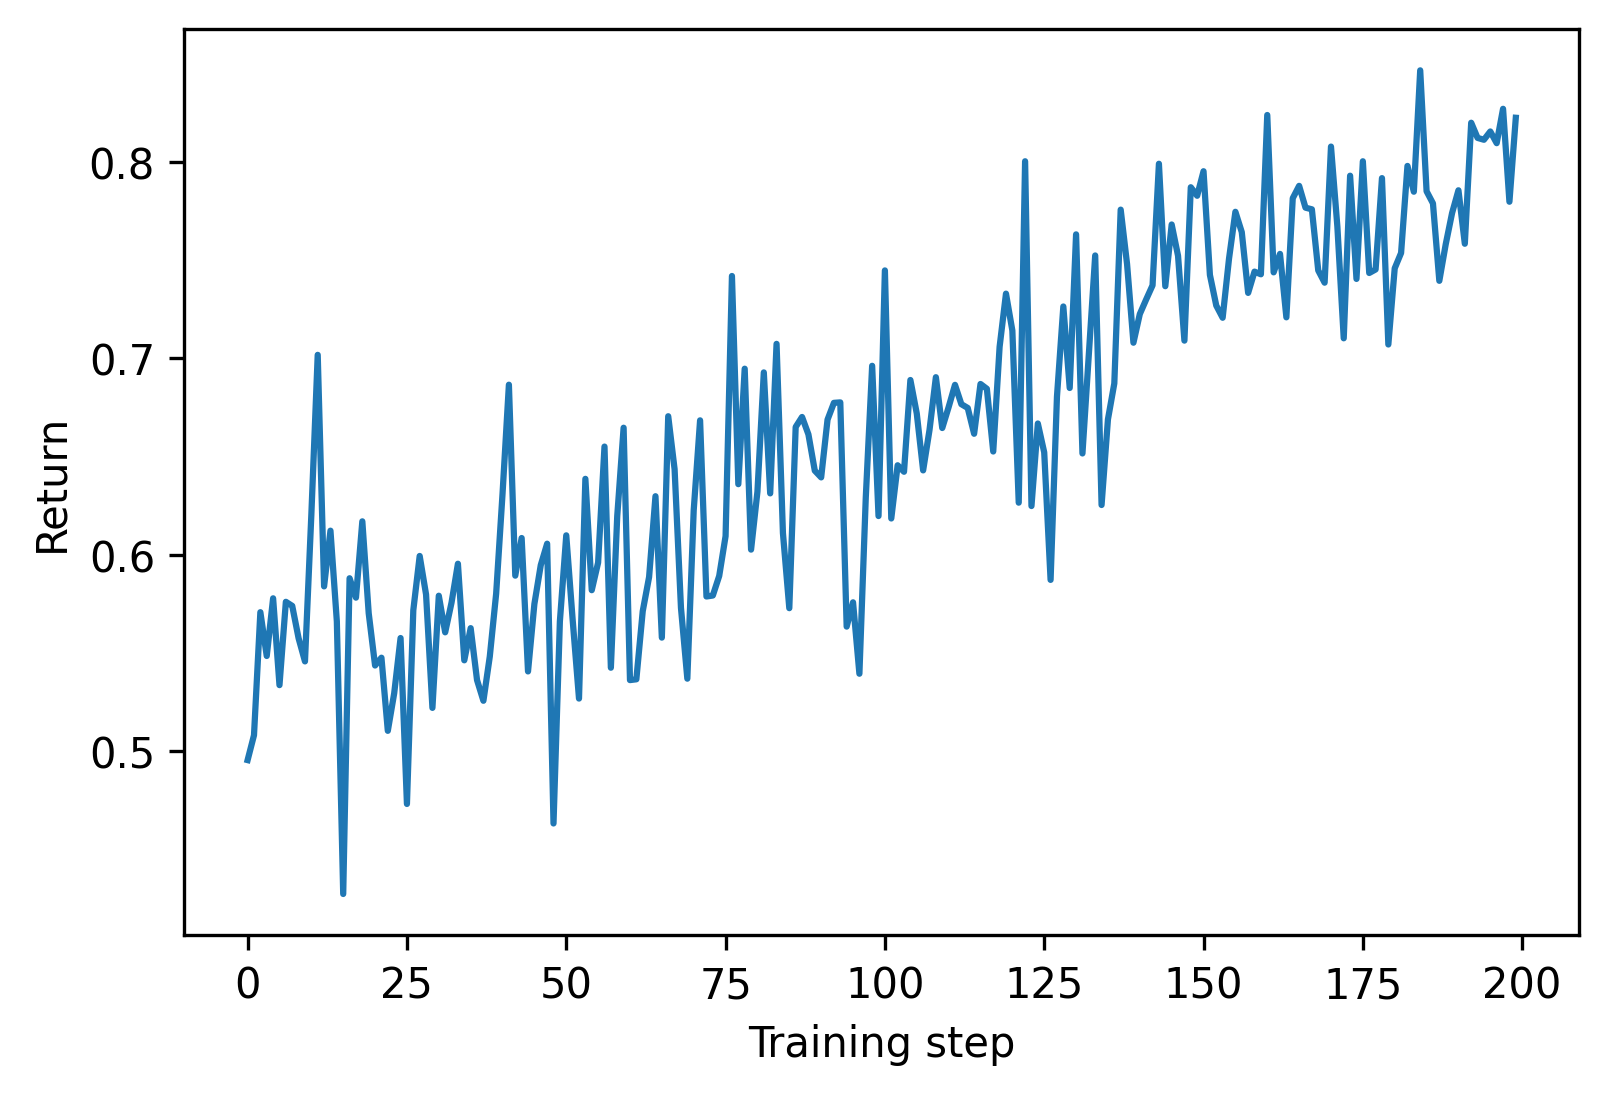

In [9]:
# If reward is evaluated only at the final time step, then 
# the y-axis corresponds to the overlap of the final state 
# with the target state. Otherwise, the y-axis is the sum of the 
# overlaps at all the time steps.

fig = plt.figure(dpi=300)
ax = plt.axes()

ax.plot(learner.return_history)

ax.set_xlabel('Training step')
ax.set_ylabel('Return')

plt.show()

### Test the network

In [10]:
# Run a batch of initial states
learner.run_trajectory()
learner.update_policy_gradient() # just for getting access to the return R

print(np.mean(learner.return_R))

0.8224899288371158


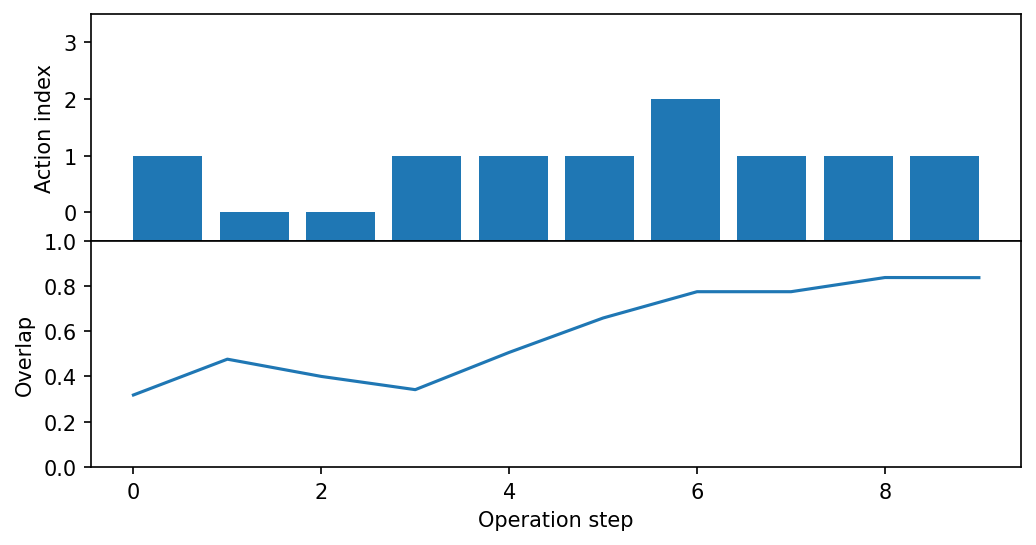

In [11]:
# investigate one particular case of the batch in detail
batch_idx = 11

fig, ax = plt.subplots(nrows=2, dpi=150, figsize=(8,4))

# Action operations vs time
# y=n => action=n
ax[0].bar(np.arange(num_steps), learner.action_history[:,batch_idx]+1, bottom=-1)
ax[0].set_ylim(-0.5,num_actions+0.5)

ax[0].set_xticks([])
ax[0].set_ylabel('Action index')

# Reward (overlap) vs time
overlap = environment.overlap(learner.state_history[:,batch_idx,:3], target_state)
ax[1].plot(overlap)
ax[1].set_ylim(0.0,1)

ax[1].set_xlabel('Operation step')
ax[1].set_ylabel('Overlap')

plt.subplots_adjust(hspace=0.0)

plt.show()

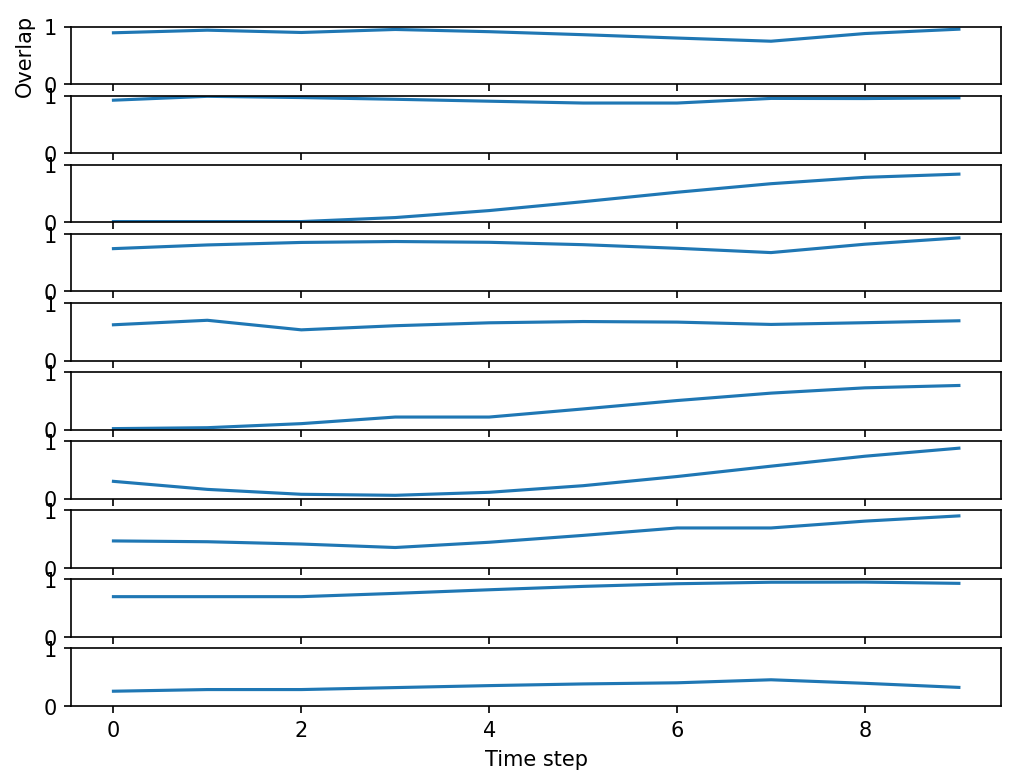

In [12]:
# investigate the overlaps of many cases in the batch
N_cases = 10
batch_idx = np.arange(N_cases)

fig, ax = plt.subplots(nrows=N_cases, dpi=150, figsize=(8,6))

# Overlap vs time
for idx in range(N_cases):
    overlap = environment.overlap(learner.state_history[:,idx,:3], target_state)
    ax[idx].plot(overlap)
    ax[idx].set_ylim(0.0,1)

ax[N_cases-1].set_xlabel('Time step')
ax[0].set_ylabel('Overlap')

plt.subplots_adjust(hspace=0.2)

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=257edd66-166e-407b-a4a5-f8a466bff41d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>